Автокодировщики - это класс нейронных сетей, которые пытаются реконструировать входные данные с применением обратного распространения. Автокодировщик состоит из двух частей: кодировщик и декодер. Кодировщик читает входные данные и сжимает их, порождая более компактное представление, а декодер читает это представление и пытается восстановить по нему вход. Иными словами, автокодировщик пытается обучить тождественную функцию, минимизируя ошибку реконструкции.
На первый взгляд, тождественная функция не представляет ничего интересного, но важно, как именно производится обучение. Число скрытых слоев автокодировщика обычно меньше числа входных (и выходных) блоков. Это вынуждает кодировщик обучаться сжатому представлению входа, которое декодер реконструирует. Если входные данные обладают структурой в виде корреляций между входными признаками, то автокодировщик выявит некоторые корреляции и в итоге обучится представлению данных меньшей размерности аналогично тому, как это делается в методе главных компонент (principal component analysis, РСА)

Обучив автокодировщик, декодер обычно отбрасывают и используют только кодировщик для порождения компактных представлений входных данных. Можно вместо этого использовать кодировщик как детектор признаков, порождающий компактное, семантически полноценное представление входа, и построить классификатор, присоединив к скрытому слою слой с функцией активации softmax.

Ранее мы уже встречались с погружениями слов, в результате чего получается вектор, представляющий смысл слова в контексте других слов, совместно с которыми оно встречается. А сейчас мы посмотрим, как построить аналогичные векторы для предложений. Предложение - это последовательность слов, а вектор предложения представляет его смысл.
Самый простой способ построить вектор предложения - сложить все векторы слов и поделить сумму на число слов. Но в этом случае предложение трактуется как мешок слов, и порядок слов не принимается во внимание. При таком подходе предложения The dog bit the man (Собака укусила человека) и The man bit the dog (Человек укусил собаку) считались бы идентичными. LSTM предназначена для работы с входными последовательностями и учитывает порядок слов, поэтому является более естественным представлением предложения.

### ИСТОЧНИКИ

https://www.kaggle.com/tunguz/russian-glove/downloads/russian-glove.zip/1



In [105]:
import collections
import nltk
import os
import numpy as np

In [5]:
def stream_sentences(src = "data/poems.txt"):
    file_path_src = src
    allHaiku = []
    with open(file_path_src, encoding="utf-8") as f:
        lines = f.readlines()
        by3lines = []
        for line in lines:
            if line == "\n":
                allHaiku.append(by3lines)
                by3lines = []
            else:
                by3lines.append(line.lower())
    return allHaiku

In [6]:
def to_oneline(data):
    return ["".join(row) for row in data]

In [89]:
sents = to_oneline(stream_sentences())

Download glove file from Kaggle to data directory

https://www.kaggle.com/tunguz/russian-glove

TODO: request file from shareable URL

In [90]:
def load_glove_vectors(glove_file, embed_size=300):
    words = [
        "PAD",
        "UNK"]
    vects = [
        np.zeros((embed_size)), # PAD
        np.random.uniform(-1, 1, embed_size)] # UNK

    fglove = open(glove_file, "rb")
    for line in fglove:
        cols = line.strip().split()
        word = cols[0].decode('utf-8')
        vect = np.array([float(v) for v in cols[1:]])
        words.append(word)
        vects.append(vect)

    vocab = {w: i for i, w in enumerate(words)}
    return words, vocab, np.array(vects)

In [91]:
words, vocab, embeddings = load_glove_vectors("data/multilingual_embeddings.ru")

In [80]:
embeddings.shape

(63070, 300)

In [81]:
vocab["и"]

13027

In [82]:
words[13027]

'и'

In [92]:
def safe_word2id(word, vocab):
    return vocab["UNK"] if vocab.get(word) == None else vocab[word]

In [96]:
from keras.preprocessing import sequence

SEQUENCE_LEN = 20

verse_index_vectors = [[safe_word2id(w, vocab) for w in nltk.word_tokenize(s)] for s in sents]
verse_index_vectors = sequence.pad_sequences(verse_index_vectors, SEQUENCE_LEN)

In [97]:
verse_index_vectors.shape

(7509, 20)

In [104]:
np.savetxt("data/index.txt", verse_index_vectors, delimiter="\t")
# r = np.genfromtxt("data/index.txt", delimiter="\t")

Модель автокодировщика принимает последовательность GloVe-векторов слов и обучается порождать другую последовательность, похожую на входную. LSTM-кодировщик сжимает последовательность в контекстный вектор фиксированной длины, по которой LSTM-декодер реконструирует исходную последовательность.

In [107]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function
from __future__ import absolute_import
from __future__ import unicode_literals
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Input
from keras.layers.core import RepeatVector
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.models import Model
from keras.preprocessing import sequence
import collections
import nltk
import numpy as np
import os
import matplotlib.pyplot as plt
from time import gmtime, strftime

In [108]:
# msin
def compute_cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x, 2) * np.linalg.norm(y, 2))

In [109]:
# split sentences into training and test
train_size = 0.7
Xtrain, Xtest = train_test_split(verse_index_vectors, train_size=train_size)
print("number of sentences: ", len(verse_index_vectors))
print(Xtrain.shape, Xtest.shape)

number of sentences:  7509
(5256, 20) (2253, 20)


/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [110]:
def sentence_generator(X, embeddings, batch_size):
    while True:
        # loop once per epoch
        num_recs = X.shape[0]
        indices = np.random.permutation(np.arange(num_recs))
        num_batches = num_recs // batch_size
        for bid in range(num_batches):
            sids = indices[bid * batch_size: (bid + 1) * batch_size]
            Xbatch = embeddings[X[sids, :]]
            yield Xbatch, Xbatch

In [111]:
embeddings.shape

(63070, 300)

In [112]:
Xtrain.shape

(5256, 20)

In [113]:
Xtest.shape

(2253, 20)

In [115]:
# define training and test generators
BATCH_SIZE = 64
train_gen = sentence_generator(Xtrain, embeddings, BATCH_SIZE)
test_gen = sentence_generator(Xtest, embeddings, BATCH_SIZE)

In [116]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import unicode_literals
from time import gmtime, strftime
from keras.callbacks import TensorBoard
import os


def make_tensorboard(set_dir_name=''):
    tictoc = strftime("%a_%d_%b_%Y_%H_%M_%S", gmtime())
    directory_name = tictoc
    log_dir = set_dir_name + '_' + directory_name
    os.mkdir(log_dir)
    tensorboard = TensorBoard(log_dir=log_dir, write_graph=True, )
    return tensorboard

In [117]:
# define autoencoder network
EMBED_SIZE = 300
LATENT_SIZE = 512

inputs = Input(shape=(SEQUENCE_LEN, EMBED_SIZE), name="input")
encoded = Bidirectional(LSTM(LATENT_SIZE), merge_mode="sum",
                        name="encoder_lstm")(inputs)

decoded = RepeatVector(SEQUENCE_LEN, name="repeater")(encoded)
decoded = Bidirectional(LSTM(EMBED_SIZE, return_sequences=True),
                        merge_mode="sum",
                        name="decoder_lstm")(decoded)

autoencoder = Model(inputs, decoded)

tensorboard = make_tensorboard(set_dir_name='rnn')

autoencoder.compile(optimizer="sgd", loss="mse")

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [119]:
# train
NUM_EPOCHS = 10
DATA_DIR = "data"

num_train_steps = len(Xtrain) // BATCH_SIZE
num_test_steps = len(Xtest) // BATCH_SIZE

checkpoint = ModelCheckpoint(
    filepath=os.path.join(DATA_DIR, "sent-thoughts-autoencoder.h5"),
    save_best_only=True)

history = autoencoder.fit_generator(train_gen,
                                    steps_per_epoch=num_train_steps,
                                    epochs=NUM_EPOCHS,
                                    validation_data=test_gen,
                                    validation_steps=num_test_steps,
                                    callbacks=[checkpoint, tensorboard])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
82/82 [==============================] - 48s 581ms/step - loss: 0.1947 - val_loss: 0.1948
Epoch 2/10
82/82 [==============================] - 47s 570ms/step - loss: 0.1914 - val_loss: 0.1918
Epoch 3/10
82/82 [==============================] - 46s 561ms/step - loss: 0.1887 - val_loss: 0.1894
Epoch 4/10
82/82 [==============================] - 45s 554ms/step - loss: 0.1865 - val_loss: 0.1872
Epoch 5/10
82/82 [==============================] - 46s 557ms/step - loss: 0.1846 - val_loss: 0.1853
Epoch 6/10
82/82 [==============================] - 46s 556ms/step - loss: 0.1830 - val_loss: 0.1839
Epoch 7/10
82/82 [==============================] - 46s 559ms/step - loss: 0.1816 - val_loss: 0.1827
Epoch 8/10
82/82 [==============================] - 46s 557ms/step - loss: 0.1803 - val_loss: 0.1812
Epoch 9/10
82/82 [==============================] - 46s 556ms/step - loss: 0.1792 - val_loss: 0.1803
Epoch 10/10
82/82 [========================

In [120]:
# extract encoder model
encoder = Model(autoencoder.input, autoencoder.get_layer("encoder_lstm").output)

0.4585866630077362
0.53293377161026
0.34642577171325684
0.5201818943023682
0.3025127053260803
0.3962501883506775
0.3903942406177521
0.37477990984916687
0.1981249302625656
0.5313827991485596
0.3183656334877014


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


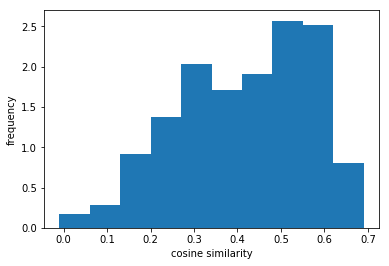

In [121]:
# collect autoencoder predictions for test set
test_inputs, test_labels = next(test_gen)
preds = autoencoder.predict(test_inputs)

# compute difference between vector produced by original and autoencoded
k = 500
cosims = np.zeros((k))
i = 0
for bid in range(num_test_steps):
    xtest, ytest = next(test_gen)
    ytest_ = autoencoder.predict(xtest)
    Xvec = encoder.predict(xtest)
    Yvec = encoder.predict(ytest_)
    for rid in range(Xvec.shape[0]):
        if i >= k:
            break
        cosims[i] = compute_cosine_similarity(Xvec[rid], Yvec[rid])
        if i <= 10:
            print(cosims[i])
        i += 1
    if i >= k:
        break

plt.hist(cosims, bins=10, normed=True)
plt.xlabel("cosine similarity")
plt.ylabel("frequency")
plt.show()